### Data preparation and preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df.head()
df.info()
df.shape
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,Unnamed: 83,hospital_death
count,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,88993.000000,...,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,0.0,91713.000000
mean,65606.079280,65537.131464,105.669262,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,84.028340,...,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638,NaN,0.086302
std,37795.088538,37811.252183,62.854406,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,25.011497,...,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169,NaN,0.280811
min,1.000000,1.000000,2.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,38.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,32852.000000,32830.000000,47.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,66.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
50%,65665.000000,65413.000000,109.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,80.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
75%,98342.000000,98298.000000,161.000000,75.000000,32.930206,0.000000,177.800000,679.000000,0.409028,97.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
max,131051.000000,131051.000000,204.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,186.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000


Missing Values Checking: 

age                             4228
bmi                             3429
ethnicity                       1395
gender                            25
height                          1334
                               ...  
lymphoma                         715
solid_tumor_with_metastasis      715
apache_3j_bodysystem            1662
apache_2_bodysystem             1662
Unnamed: 83                    91713
Length: 75, dtype: int64

Target Distribution: 

hospital_death
0    83798
1     7915
Name: count, dtype: int64


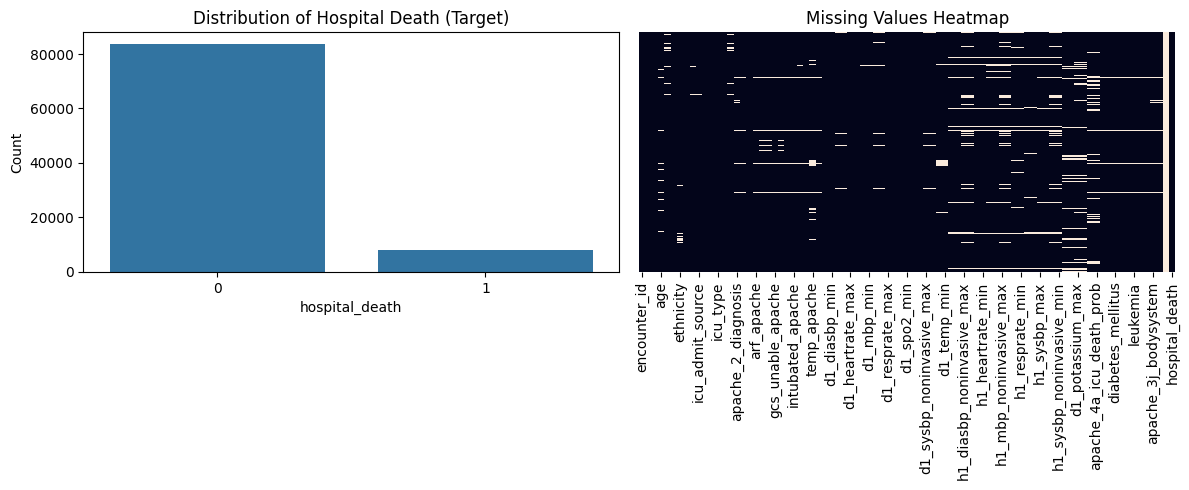

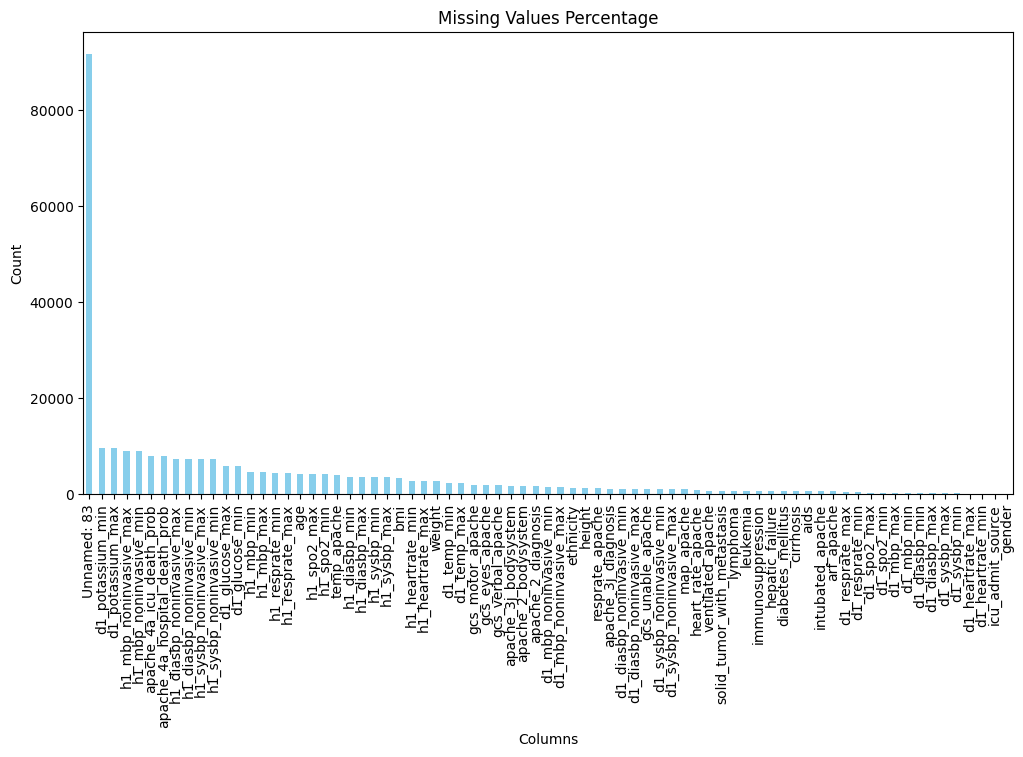

In [4]:
# Missing values per column
missing_values = df.isnull().sum()
missing_values_columns = missing_values[missing_values > 0]
print("Missing Values Checking: \n")
print(missing_values_columns)

# Check target variable distribution
target_distribution = df['hospital_death'].value_counts()
print("\nTarget Distribution: \n") 
print(target_distribution)

# Create visuals for initial insights
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot target variable distribution
sns.countplot(x='hospital_death', data=df, ax=axes[0])
axes[0].set_title('Distribution of Hospital Death (Target)')
axes[0].set_ylabel('Count')

# Missing values heatmap
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, ax=axes[1])
axes[1].set_title('Missing Values Heatmap')

plt.tight_layout()
plt.show()

# Check missing values before imputation
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Visualize missing values as a percentage
plt.figure(figsize=(12, 6))
missing_values.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Missing Values Percentage")
plt.ylabel("Count")
plt.xlabel("Columns")
plt.show()

### Building a model

   ethnicity  gender  icu_admit_source  icu_stay_type  icu_type  \
0          2       1                 1              0         2   
1          2       0                 1              0         5   
2          2       0                 0              0         5   
3          2       0                 2              0         2   
4          2       1                 0              0         5   

   apache_3j_bodysystem  apache_2_bodysystem  
0                     9                    0  
1                     8                    6  
2                     5                    3  
3                     0                    0  
4                    10                    7  
Dropped Features:
 Index(['gcs_unable_apache', 'aids', 'leukemia', 'lymphoma', 'Unnamed: 83'], dtype='object')
Selected Features:
 Index(['encounter_id', 'patient_id', 'hospital_id', 'age', 'bmi',
       'elective_surgery', 'ethnicity', 'gender', 'height', 'icu_admit_source',
       'icu_id', 'icu_stay_type', 'icu

/Users/soongjun/Library/CloudStorage/OneDrive-UniversitiMalaya/myenv/lib/python3.9/site-packages/sklearn/feature_selection/_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/soongjun/Library/CloudStorage/OneDrive-UniversitiMalaya/myenv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/soongjun/Library/CloudStorage/OneDrive-UniversitiMalaya/myenv/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Cl

Class Distribution After SMOTE: Counter({0: 83798, 1: 83798})


/var/folders/dw/gqdjz0756k11zwysr92bpkvc0000gn/T/ipykernel_4304/1977137162.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette="plasma")


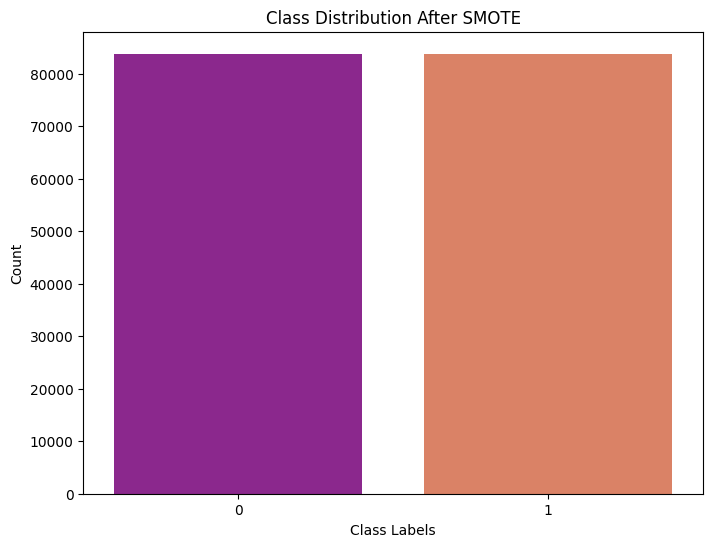

Epoch [1/10], Train Loss: 0.3731, Val Loss: 0.3013
Epoch [2/10], Train Loss: 0.3243, Val Loss: 0.2702


KeyboardInterrupt: 

In [5]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import Counter

# 1. Data Loading
df = pd.read_csv('dataset.csv')

# 2. Feature & Target Separation
X = df.drop(columns=["hospital_death"])
y = df["hospital_death"]

# 3. Handle Missing Values
# Separate numeric and categorical columns
numeric_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Fill missing values
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())  # Median for numeric
X[categorical_cols] = X[categorical_cols].fillna(X[categorical_cols].mode().iloc[0])  # Mode for categorical

# 4. Encode Categorical Data
label_encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

print(X[categorical_cols].head())

# 5. Remove Low Variance Features
selector = VarianceThreshold(threshold=0.01)
X_selected = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])

dropped_features = X.columns[~selector.get_support()]
selected_features = X.columns[selector.get_support()]

print("Dropped Features:\n", dropped_features)

print("Selected Features:\n", selected_features)
print(X.shape, X_selected.shape)

# 6. Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Print class distribution after SMOTE
print("Class Distribution After SMOTE:", Counter(y_resampled))
# Visualize class distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled, palette="plasma")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.show()

# 7. Split Data into Training and Test Sets (80%, 20%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 8. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 9. Convert Data to PyTorch Tensors
class MortalityDataset(Dataset):
    def __init__(self, X, y):
        # Convert the input features and target labels to PyTorch tensors
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Initialize datasets and loaders
train_dataset = MortalityDataset(X_train_scaled, y_train)
test_dataset = MortalityDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 11. Define the PyTorch MLP Model
class MortalityMLP(nn.Module):
    def __init__(self, input_size):
        super(MortalityMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64) # First hidden layer with 64 neurons
        self.bn1 = nn.BatchNorm1d(64) # Stable training and faster convergence speed
        self.fc2 = nn.Linear(64, 32) # Second hidden layer with 32 neurons
        self.bn2 = nn.BatchNorm1d(32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        return torch.sigmoid(self.output(x))  # Sigmoid is often used for binary classification

# 12. Initialize Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
input_size = X_train.shape[1]
model = MortalityMLP(input_size).to(device) # 
criterion = nn.BCELoss() # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 13. Train the Model
loss_values_train = []
loss_values_val = []
epochs = 10

for epoch in range(epochs):
    total_train_loss = 0
    total_val_loss = 0
    
    # Training Phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Ensure that train with GPU

        optimizer.zero_grad() #  Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        
        outputs = model(inputs) # get output from the model, given the inputs
        loss = criterion(outputs, labels)  # get loss for the predicted output
        
        # get gradients w.r.t to parameters
        loss.backward()
        # update parameters
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Validation Phase
    model.eval()
    y_pred_list, y_true_list = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
    
    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(test_loader)
    loss_values_train.append(avg_train_loss)
    loss_values_val.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Evaluate the Model
model.eval()
y_pred_list = []
y_true_list = []

# Collect all predictions and true labels
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions = ((outputs) > 0.5).float()
        y_pred_list.extend(predictions.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())

# Calculate Accuracy and Print Classification Report
accuracy = accuracy_score(y_true_list, y_pred_list)
report = classification_report(y_true_list, y_pred_list)

print("\Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

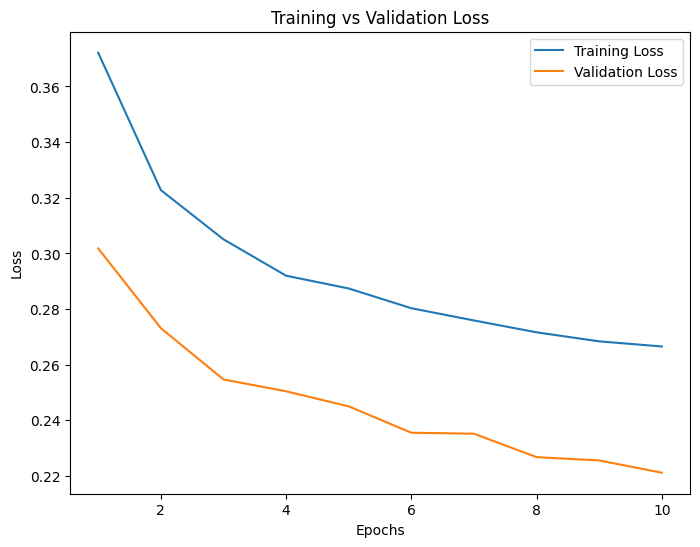

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_values_train, label="Training Loss")
plt.plot(range(1, epochs + 1), loss_values_val, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Optimizing Network Architecture - Deeper Neural NEtwork
1. Increase the number of neurons for each hidden layers
2. Additional hidden layer is added
3. Increase Dropout
4. Reduce learning rate
5. Assign weight_decay (L2 Regularization) to prevent overfitting
6. Learning Scheduler 

Epoch [1/20], Train Loss: 0.3917, Val Loss: 0.3075
Epoch [2/20], Train Loss: 0.3400, Val Loss: 0.2806
Epoch [3/20], Train Loss: 0.3162, Val Loss: 0.2657
Epoch [4/20], Train Loss: 0.3027, Val Loss: 0.2485
Epoch [5/20], Train Loss: 0.2936, Val Loss: 0.2466
Epoch [6/20], Train Loss: 0.2779, Val Loss: 0.2328
Epoch [7/20], Train Loss: 0.2752, Val Loss: 0.2290
Epoch [8/20], Train Loss: 0.2697, Val Loss: 0.2258
Epoch [9/20], Train Loss: 0.2690, Val Loss: 0.2203
Epoch [10/20], Train Loss: 0.2642, Val Loss: 0.2213
Epoch [11/20], Train Loss: 0.2599, Val Loss: 0.2170
Epoch [12/20], Train Loss: 0.2552, Val Loss: 0.2127
Epoch [13/20], Train Loss: 0.2558, Val Loss: 0.2126
Epoch [14/20], Train Loss: 0.2532, Val Loss: 0.2090
Epoch [15/20], Train Loss: 0.2511, Val Loss: 0.2112
Epoch [16/20], Train Loss: 0.2502, Val Loss: 0.2132
Epoch [17/20], Train Loss: 0.2482, Val Loss: 0.2068
Epoch [18/20], Train Loss: 0.2490, Val Loss: 0.2086
Epoch [19/20], Train Loss: 0.2468, Val Loss: 0.2059
Epoch [20/20], Train 

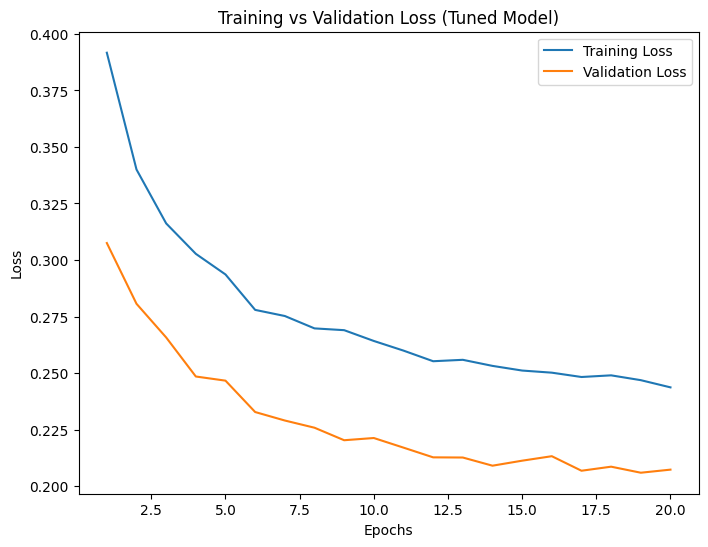


Tuned Model Accuracy: 0.9157

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.91      0.91     16674
         1.0       0.91      0.92      0.92     16846

    accuracy                           0.92     33520
   macro avg       0.92      0.92      0.92     33520
weighted avg       0.92      0.92      0.92     33520



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Model Definition with Increased Complexity and Dropout
class TunedMortalityMLP(nn.Module):
    def __init__(self, input_size):
        super(TunedMortalityMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Increase to 128 neurons
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)          # Add another layer
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)           # Another smaller layer
        self.bn3 = nn.BatchNorm1d(32)
        self.output = nn.Linear(32, 1)         # Output layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)         # Increase dropout for regularization

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        return torch.sigmoid(self.output(x))

# Initialize the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[1]
model = TunedMortalityMLP(input_size).to(device)

# Define Loss, Optimizer, and Scheduler
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay= 0.0001)  # Lower LR + L2 Regularization to avoid overfitting
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR after 5 epochs

# Training Loop with Hyperparameter Tuning
epochs = 20
loss_values_train, loss_values_val = [], []

for epoch in range(epochs):
    total_train_loss = 0
    total_val_loss = 0
    
    # Training Phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # Clear gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation Phase
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    # Record average losses
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(test_loader)
    loss_values_train.append(avg_train_loss)
    loss_values_val.append(avg_val_loss)
    
    # Step the learning rate scheduler
    scheduler.step()
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot Learning Curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_values_train, label="Training Loss")
plt.plot(range(1, epochs + 1), loss_values_val, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Tuned Model)")
plt.legend()
plt.show()

# Evaluate the Tuned Model
model.eval()
y_pred_list, y_true_list = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions = (outputs > 0.5).float()
        y_pred_list.extend(predictions.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())

accuracy = accuracy_score(y_true_list, y_pred_list)
report = classification_report(y_true_list, y_pred_list)
print(f"\nTuned Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)


**Observations:**
* The model improvements from tuning (added layers, dropout, L2 regularization, and a learning rate scheduler) have significantly boosted performance and ensured generalization.
* Both train loss and validation loss are relatively low and consistent.

# Hyperparameter Tuning
1. Grid Search is used with different combination of:
* Learning rate
* Epochs
* Dropout
* Batch Sizes 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import itertools
import numpy as np

# Define Hyperparameter Grid
learning_rates = [0.001, 0.0005]
epochs_list = [10, 20]
dropout_rates = [0.2, 0.3]
batch_sizes = [64, 128]

# Generate all combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(learning_rates, epochs_list, dropout_rates, batch_sizes))

# Model Definition with Dropout as a Hyperparameter
class TunedMortalityMLP(nn.Module):
    def __init__(self, input_size, dropout_rate):
        super(TunedMortalityMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        return torch.sigmoid(self.output(x))

# Function to Train and Evaluate Model
def train_and_evaluate_model(lr, epochs, dropout_rate, batch_size):
    # Prepare DataLoader
    train_dataset = MortalityDataset(X_train_scaled, y_train)
    test_dataset = MortalityDataset(X_test_scaled, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize Model, Loss, and Optimizer
    model = TunedMortalityMLP(input_size, dropout_rate).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training Loop
    model.train()
    for epoch in range(epochs):
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

    # Evaluation Loop
    model.eval()
    y_pred_list = []
    y_true_list = []
    total_val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            preds = (outputs > 0.5).float()
            y_pred_list.extend(preds.cpu().numpy())
            y_true_list.extend(labels.cpu().numpy())

    # Calculate Loss and Accuracy
    avg_val_loss = total_val_loss / len(test_loader)
    val_accuracy = accuracy_score(y_true_list, y_pred_list)

    return avg_val_loss, val_accuracy

# Hyperparameter Tuning Loop
results = []
for lr, epochs, dropout_rate, batch_size in hyperparameter_combinations:
    print(f"Testing Configuration: LR={lr}, Epochs={epochs}, Dropout={dropout_rate}, Batch Size={batch_size}")
    val_loss, val_accuracy = train_and_evaluate_model(lr, epochs, dropout_rate, batch_size)
    results.append((lr, epochs, dropout_rate, batch_size, val_loss, val_accuracy))
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n")

# Identify Best Configuration
best_config = min(results, key=lambda x: x[4])  # Sort by lowest validation loss
print("\nBest Hyperparameter Configuration:")
print(f"Learning Rate: {best_config[0]}, Epochs: {best_config[1]}, Dropout: {best_config[2]}, Batch Size: {best_config[3]}")
print(f"Best Validation Loss: {best_config[4]:.4f}, Best Validation Accuracy: {best_config[5]:.4f}")


Testing Configuration: LR=0.001, Epochs=10, Dropout=0.2, Batch Size=64
Validation Loss: 0.2002, Validation Accuracy: 0.9180

Testing Configuration: LR=0.001, Epochs=10, Dropout=0.2, Batch Size=128
Validation Loss: 0.1931, Validation Accuracy: 0.9219

Testing Configuration: LR=0.001, Epochs=10, Dropout=0.3, Batch Size=64
Validation Loss: 0.2147, Validation Accuracy: 0.9133

Testing Configuration: LR=0.001, Epochs=10, Dropout=0.3, Batch Size=128


KeyboardInterrupt: 